In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/My Drive/Airlines'

/content/drive/My Drive/Airlines


# Künstliches Neuronales Netz

## Lade benötigte Pakete und Daten

In [ ]:
import pandas as pd
from fastai import * 
from fastai.tabular import *
from sklearn.model_selection import train_test_split

In [ ]:
train_set = pd.read_csv('data/train_set.csv')
train_set.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,0,1,42,1,0,1304,2,4,4,4,2,2,2,2,3,3,4,2,4,2,0,0.0
1,1,0,1,57,1,2,844,1,1,1,1,2,4,5,4,4,4,4,4,4,3,18,19.0
2,1,0,1,39,1,0,1716,4,2,2,2,4,4,4,4,1,4,3,1,3,4,1,0.0
3,0,1,1,42,1,2,1177,2,5,3,5,3,4,4,2,2,2,2,2,2,2,11,19.0
4,1,1,1,39,1,2,2017,3,3,3,3,4,4,5,5,5,5,5,4,5,5,7,29.0


__Trainings- und Validierungsset__

Um die Sets zu erstellen, werden Indizes erstellt. Zudem müssen kategorische sowie kontinuierliche Variablen gekennzeichnet und die durchzuführenden Bearbeitungen der Daten (Procs) angegeben werden.

In [ ]:
dep_var = 'satisfaction'
cat_names = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 
             'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support','Ease of Online booking', 'On-board service', 'Leg room service', 
             'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']
cont_names = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

In [ ]:
procs = [FillMissing, Categorify, Normalize]

In [ ]:
train_idx, valid_idx = train_test_split(range(len(train_set)), test_size=0.2, random_state = 30)

Lade Daten in den DataBunch:

In [ ]:
data = TabularDataBunch.from_df('data', train_set, dep_var, valid_idx=valid_idx, 
                                procs=procs, cat_names=cat_names, cont_names=cont_names, bs=128)

In [ ]:
data.show_batch(5)

Gender,Customer Type,Type of Travel,Class,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,target
1,1,1,2,2,2,2,2,4,5,5,4,4,4,4,5,4,3,1.1618,0.7453,-0.2400,-0.4669,1
0,1,1,2,5,5,5,5,5,5,5,5,2,1,3,3,2,5,-1.0892,1.0716,0.0540,-0.0665,1
0,1,1,2,1,1,1,1,5,5,5,5,4,4,4,3,5,5,-1.0230,0.2499,-0.4606,-0.4669,1
1,1,1,2,5,5,5,5,4,5,4,4,4,4,4,3,4,5,0.5660,1.1764,-0.4606,-0.4669,1
0,0,1,2,3,3,3,2,4,3,4,4,5,2,5,3,5,4,-0.4934,-0.7121,1.4876,1.0983,0


### Trainiere Modell mit fastai v1 TabLearner

Wie groß sollen die einzelnen Schichten des Netzes werden? Ein Ansatz ist hier zu finden: https://forums.fast.ai/t/an-attempt-to-find-the-right-hidden-layer-size-for-your-tabular-learner/45714

In [ ]:
def calcHiddenLayer(data, alpha, numHiddenLayers):
  tempData = data.train_ds
  i, o = len(tempData.x.classes), len(tempData.y.classes)
  io = i+o
  return [(len(data.train_ds)//(alpha*(io)))//numHiddenLayers]*numHiddenLayers

In [ ]:
calcHiddenLayer(data, 4, 2)

[514, 514]

Anschließend wird der *learner* mit Daten, Architektur und Metriken erstellt. Durch den *learning rate-finder* wird das Finden einer guten *Learning Rate* deutlich einfacher.

In [ ]:
learn = tabular_learner(data, layers=[824,412], metrics=[accuracy, FBeta(beta=0.5)])

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


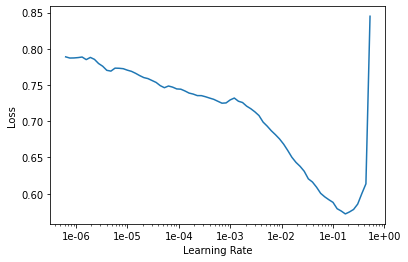

In [ ]:
learn.recorder.plot()

Nachdem eine gute *Learning Rate* gefunden wurde, kann die Erstellung des DataBunch, die Erstellung des *Learner*, das Training des Modells sowie das Speichern in einer Funktion ausgeführt werden. Dies spart repetitive Arbeit und gestaltet das Notebook übersichtlicher. Um die Schritte der Funktion auszuführen, müssen nur die Größe der Schichten und die *Batch Size* angegeben werden.

In [ ]:
def train_model(layer1, layer2, bs, epochs):

  df = pd.read_csv('data/train_set.csv')
  procs = [FillMissing, Categorify, Normalize]
  dep_var = 'satisfaction'
  cat_names = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 
              'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support','Ease of Online booking', 'On-board service', 'Leg room service', 
              'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']
  cont_names = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

  train_idx, valid_idx = train_test_split(range(len(df)), test_size=0.2, random_state = 7)

  data = TabularDataBunch.from_df('',df, dep_var, valid_idx=valid_idx, 
                                  procs=procs, cat_names=cat_names, cont_names=cont_names, bs=bs)


  learn = tabular_learner(data, layers=[layer1, layer2], metrics=[accuracy, FBeta(beta=0.5)])

  learn.fit_one_cycle(epochs, max_lr=slice(4e-2))

  learn.recorder.plot_losses()

  learn.export('export/learner_'+str(layer1)+'x'+str(layer2)+'-bs'+str(bs)+'_'+str(epochs)+'epochs.pkl')

  response = 'Modell erfolgreich trainiert und exportiert'
  return response

Auf diese Weise werden drei Modelle mit verschiedenen Schichtgrößen und *Batch Sizes* trainiert.

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.139349,0.125538,0.941966,0.941897,00:13
1,0.131081,0.119362,0.948381,0.952846,00:13
2,0.128981,0.141821,0.946534,0.967561,00:14
3,0.140406,0.116133,0.947555,0.955069,00:13
4,0.118690,0.182352,0.950180,0.964151,00:13
5,0.120495,5.792440,0.952367,0.954288,00:14
6,0.122772,0.737911,0.949888,0.948771,00:14
7,0.111595,0.116210,0.950374,0.976571,00:14
8,0.106006,0.291854,0.956547,0.967408,00:14
9,0.097906,1.196373,0.955478,0.963318,00:14


'Modell erfolgreich trainiert und exportiert'

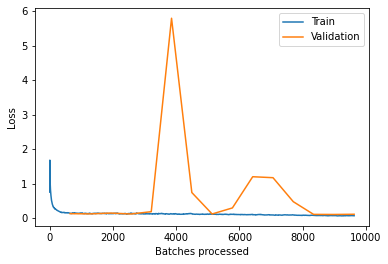

In [ ]:
train_model(824, 412, 128, 15)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.137287,0.130222,0.946340,0.952985,00:23
1,0.143683,0.122297,0.947215,0.959431,00:23
2,0.142435,0.159918,0.947312,0.950758,00:23
3,0.147119,0.131304,0.946729,0.953436,00:23
4,0.138328,0.123972,0.948527,0.954925,00:23
5,0.129222,0.107385,0.951832,0.956163,00:23
6,0.124819,0.227366,0.946534,0.951020,00:23
7,0.142680,0.390114,0.917955,0.900041,00:23
8,0.118047,7.211229,0.950034,0.968510,00:23
9,0.115708,0.105884,0.956936,0.967225,00:23


'Modell erfolgreich trainiert und exportiert'

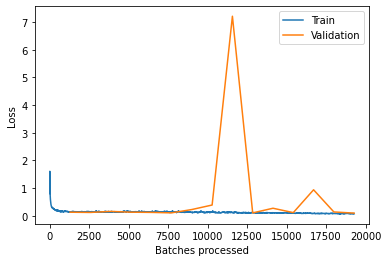

In [ ]:
train_model(514, 514, 64, 15)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.155037,0.131383,0.945368,0.955684,00:45
1,0.153813,0.166353,0.936570,0.935246,00:45
2,0.176251,0.145969,0.939876,0.966291,00:45
3,0.160079,0.128451,0.945368,0.952982,00:45
4,0.191426,0.490276,0.938466,0.932853,00:46
5,0.181583,1.126023,0.943667,0.945511,00:45
6,0.197091,5.275575,0.939924,0.954387,00:45
7,0.152346,1.765877,0.942938,0.943395,00:45
8,0.162198,3.269657,0.945125,0.944403,00:46
9,0.119580,1.222656,0.943424,0.946536,00:45


'Modell erfolgreich trainiert und exportiert'

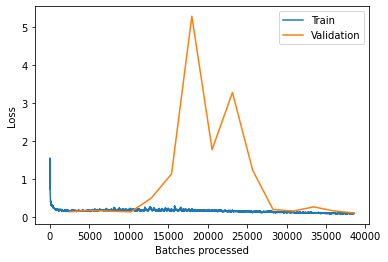

In [ ]:
train_model(1000, 500, 32, 15)

### Modellevaluation

Lade Testdatensatz. *fastai v1* macht das Evaluieren auf Testdatensätzen etwas umständlich: Da Testdaten bei *fastai* stets ungelabelt sind und wir die *Labels* benötigen, um den Anteil der richtig klassifizierten Einträge zu berechnen, müssen wir das Testset als Validierungsset in den DataBunch laden. Hierfür werden Trainings- und Testset zu einem *DataFrame* vereint und beim Laden in den *DataBunch* durch die entsprechenden Indizes wieder getrennt.

In [ ]:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')

In [ ]:
len(test_set)

25717

In [ ]:
len(train_set)

102866

In [ ]:
df_new = train_set.append(test_set); df_new

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,0,1,42,1,0,1304,2,4,4,4,2,2,2,2,3,3,4,2,4,2,0,0.0
1,1,0,1,57,1,2,844,1,1,1,1,2,4,5,4,4,4,4,4,4,3,18,19.0
2,1,0,1,39,1,0,1716,4,2,2,2,4,4,4,4,1,4,3,1,3,4,1,0.0
3,0,1,1,42,1,2,1177,2,5,3,5,3,4,4,2,2,2,2,2,2,2,11,19.0
4,1,1,1,39,1,2,2017,3,3,3,3,4,4,5,5,5,5,5,4,5,5,7,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25712,1,0,1,51,1,0,1878,4,3,3,3,4,4,4,4,5,3,3,3,5,4,0,0.0
25713,1,1,1,55,0,2,326,2,2,2,2,5,5,5,5,5,2,5,4,4,5,0,0.0
25714,0,0,1,55,0,0,1923,3,4,3,2,4,3,4,4,3,2,4,5,4,4,0,0.0
25715,1,0,1,58,1,2,1120,4,4,4,4,3,5,5,5,5,5,5,5,5,5,0,0.0


In [ ]:
valid_idx = range(102865,128582); valid_idx

range(102865, 128582)

Erstelle eine Funktion für das Laden der Daten in den DataBunch und des trainierten Modells. Die Batch Size wird hier bereits auf 500 gesetzt, um später globale Analysen mit SHAP durchführen zu können:

In [ ]:
def load_model(learner_name):

  train_set = pd.read_csv('data/train_set.csv')
  test_set = pd.read_csv('data/test_set.csv')
  df_new = train_set.append(test_set); df_new

  procs = [FillMissing, Categorify, Normalize]
  valid_idx = range(102865,128582)
  
  dep_var = 'satisfaction'

  cat_names = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 
              'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support','Ease of Online booking', 'On-board service', 'Leg room service', 
              'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']
  cont_names = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

  data = TabularDataBunch.from_df('',df_new, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names, cont_names=cont_names, bs=500)

  learn = load_learner(path='export', file=str(learner_name))

  learn.data = data

  return learn

Erstelle Funktion, die ein Modell auf Genauigkeit und Fbeta(0,5)-Wert evaluiert:

In [ ]:
def test_model(learner_name):

  learn=load_model(learner_name)

  accuracy = learn.validate()[1]
  fbeta = learn.validate()[2]
  rd_acc = round(accuracy.item(), 4)
  rd_fbeta = round(fbeta.item(), 4)

  response = "Die Accuracy des Modells beträgt "+"{0:.2%}".format(rd_acc)+", der Fbeta-Score liegt bei "+"{0:.2%}".format(rd_fbeta)

  return response

Evaluiere die drei trainierten Modelle:

In [ ]:
test_model('learner_824x412-bs128_15epochs.pkl')

'Die Accuracy des Modells beträgt 95.85%, der Fbeta-Score liegt bei 94.50%'

In [ ]:
test_model('learner_514x514-bs64_15epochs.pkl')

'Die Accuracy des Modells beträgt 95.86%, der Fbeta-Score liegt bei 94.90%'

In [ ]:
test_model('learner_1000x500-bs32_15epochs.pkl')

'Die Accuracy des Modells beträgt 95.84%, der Fbeta-Score liegt bei 94.78%'

Hier können einige Vorhersagen betrachtet werden:

In [ ]:
learn = load_model('learner_514x514-bs64_15epochs.pkl')
preds = learn.get_preds(ds_type=DatasetType.Valid)
learn.show_results(ds_type=DatasetType.Valid)

Gender,Customer Type,Type of Travel,Class,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,target,prediction
0,1,1,2,5,5,5,5,4,5,5,5,5,5,5,3,5,4,0.3659,-1.4301,0.4961,1.8285,1,1
0,0,1,2,1,1,1,3,1,1,1,1,4,3,5,4,5,1,-0.8923,0.6777,-0.4594,-0.4663,0,0
0,1,1,2,3,3,3,3,2,5,4,4,4,4,4,5,4,5,0.6970,0.4554,-0.4594,-0.4663,1,1
1,1,0,0,4,4,4,4,3,5,5,5,5,5,5,4,5,2,0.8294,-0.9827,-0.4594,-0.4663,1,1
1,1,0,0,1,1,1,1,3,5,4,4,4,4,4,3,4,4,-1.0247,-1.0884,-0.0551,-0.4299,1,1


## SHAP

Installiere/lade SHAP-Tool und lade bestes Modell:

In [ ]:
!pip install shap
import shap

     |████████████████████████████████| 327kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456450 sha256=a943b5ab329fe3cc1b0ce859a2d47df1c283ff357ecf8573b9f36605a17187e0
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [ ]:
learn = load_model('learner_514x514-bs64_15epochs.pkl'); learn.data

TabularDataBunch;

Train: LabelList (102866 items)
x: TabularList
Gender 0; Customer Type 1; Type of Travel 1; Class 0; Seat comfort 2; Departure/Arrival time convenient 4; Food and drink 4; Gate location 4; Inflight wifi service 2; Inflight entertainment 2; Online support 2; Ease of Online booking 2; On-board service 3; Leg room service 3; Baggage handling 4; Checkin service 2; Cleanliness 4; Online boarding 2; Age 0.1672; Flight Distance -0.6558; Departure Delay in Minutes -0.4594; Arrival Delay in Minutes -0.4663; ,Gender 0; Customer Type 1; Type of Travel 1; Class 2; Seat comfort 1; Departure/Arrival time convenient 1; Food and drink 1; Gate location 1; Inflight wifi service 2; Inflight entertainment 4; Online support 5; Ease of Online booking 4; On-board service 4; Leg room service 4; Baggage handling 4; Checkin service 4; Cleanliness 4; Online boarding 3; Age 1.1605; Flight Distance -1.1101; Departure Delay in Minutes 0.2021; Arrival Delay in Minutes 0.2258; ,Gender 0; Customer T

Das Verwenden von SHAP für *PyTorch* und insbesondere *fastai* ist im Vergleich zu den *sklearn*-Modellen komplexer, da nicht direkt Daten aus dem *DataBunch* übergeben werden können. Glücklicherweise konnte in den Tiefen des *fastai*-Forums Code für genau dieses Problem gefunden werden: https://forums.fast.ai/t/feature-importance-in-deep-learning/42026/64


In [ ]:
def pred(data):
    device = learn.data.device
    cat_cols = len(learn.data.train_ds.x.cat_names)
    cont_cols = len(learn.data.train_ds.x.cont_names)
    x_cat = torch.from_numpy(data[:, :cat_cols]).to(device, torch.int64)
    x_cont = torch.from_numpy(data[:, -cont_cols:]).to(device, torch.float32)
    pred_proba = learn.model(x_cat, x_cont).detach().to('cpu').numpy()
    return pred_proba

def shap_data(data):    
    X_train, y_train = data.one_batch(denorm=False, cpu=False)
    X_test, y_test = data.one_batch(denorm=False, cpu=False)
    cols = data.train_ds.x.col_names
    X_train = pd.DataFrame(np.concatenate([v.to('cpu').numpy() for v in X_train], axis=1), columns=cols)
    X_test = pd.DataFrame(np.concatenate([v.to('cpu').numpy() for v in X_test], axis=1), columns=cols)
    return X_train, X_test

In [ ]:
X_train, X_test = shap_data(learn.data)
e = shap.KernelExplainer(pred, X_train)

### Lokale Interpretationen

Hier werden einige Vorhersagen interpretierbar gemacht. Zu beachten ist, dass die Option 

```python
link='logit'
```
es ermöglicht die Variableneinflüsse als Veränderungen der Wahrscheinlichkeit zwischen 0 und 1 darstellen zu lassen. Per *default* werden normalerweise *log odds*-Werte dargestellt (s. https://github.com/slundberg/shap/issues/29).


In [ ]:
choosen_instance = X_test.loc[[421]]
shap_values = e.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(e.expected_value[1], shap_values[1], choosen_instance, link='logit')

In [ ]:
choosen_instance = X_test.loc[[122]]
shap_values = e.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(e.expected_value[1], shap_values[1], choosen_instance, link='logit')

In [ ]:
choosen_instance = X_test.loc[[200]]
shap_values = e.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(e.expected_value[1], shap_values[1], choosen_instance, link='logit')

In [ ]:
choosen_instance = X_test.loc[[67]]
shap_values = e.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(e.expected_value[1], shap_values[1], choosen_instance, link='logit')

### Globale Interpretationen

Hier werden globale Interpretationen mehrerer Vorhersagen ermöglicht. Zuerst wird für jede Variable ein *Dependence plot* gezeichnet, bei denen auf der x-Achse der Wert der Variable, auf der y-Achse der SHAP-Wert und durch die Färbung die am stärksten interagierende andere Variable illustriert wird. 

In [ ]:
shap_values = e.shap_values(X_test, nsamples=200, l1_reg=False)

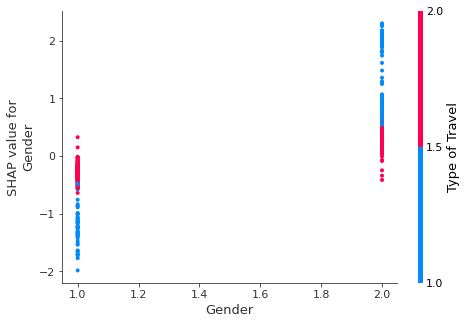

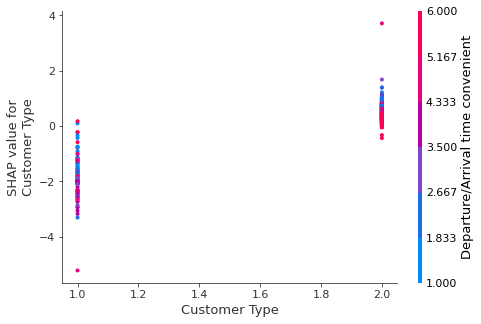

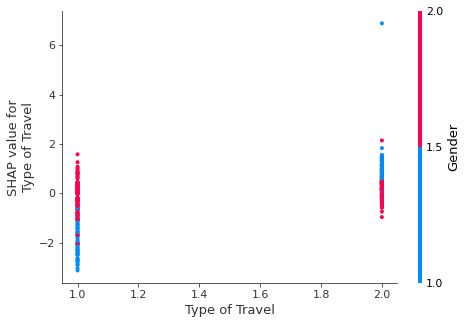

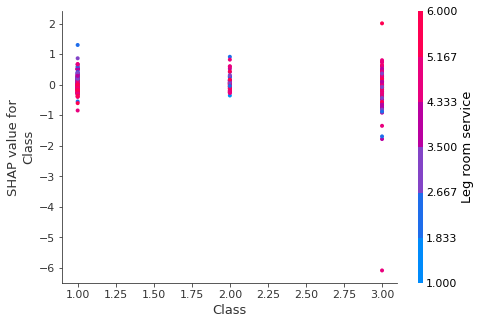

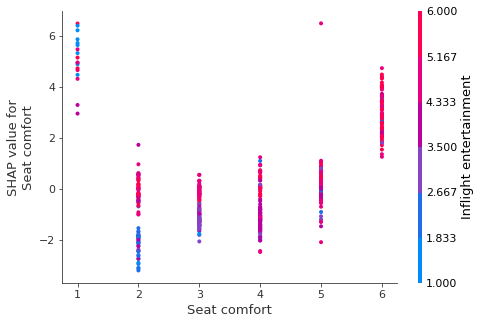

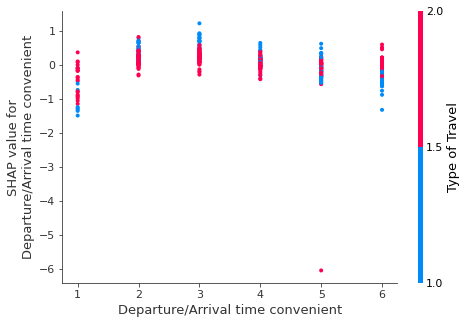

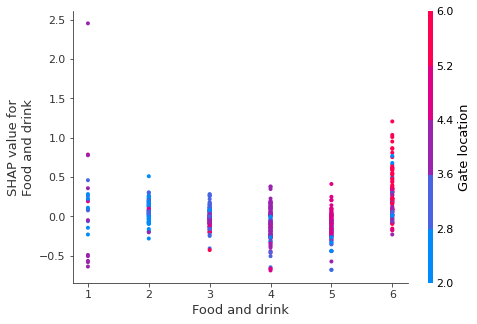

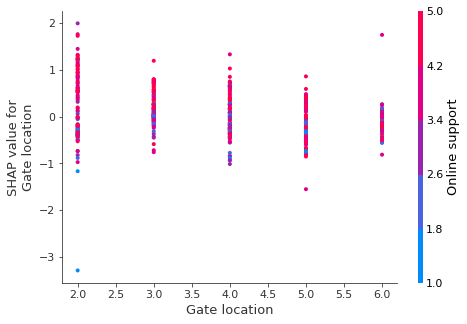

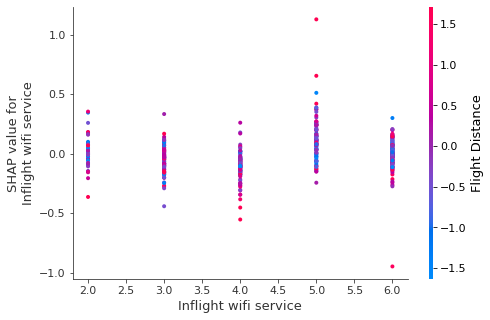

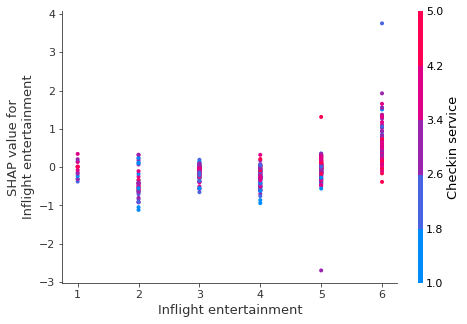

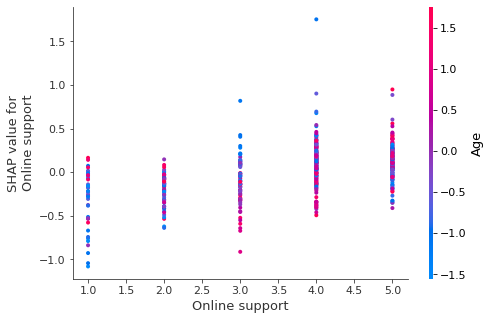

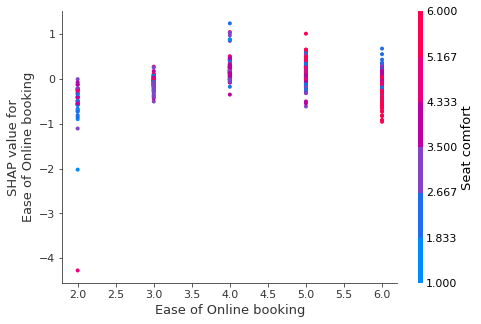

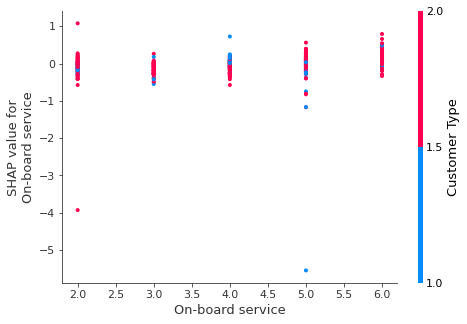

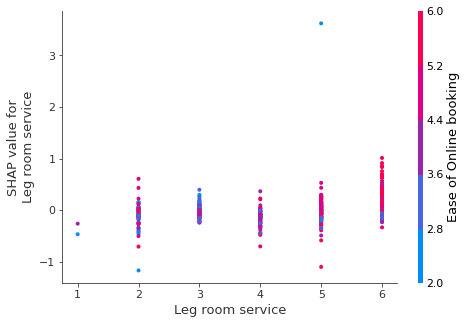

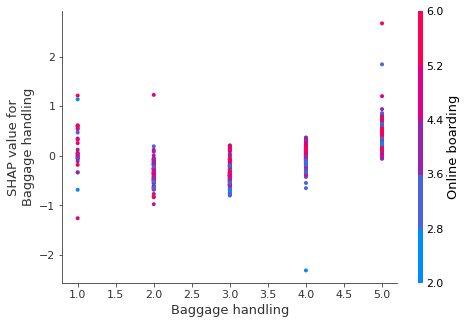

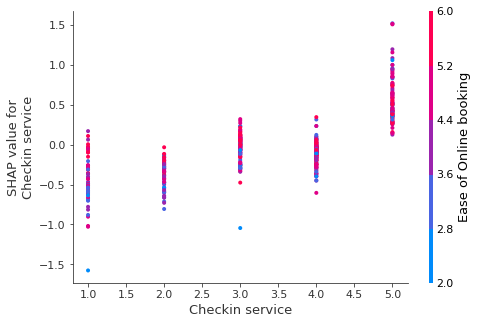

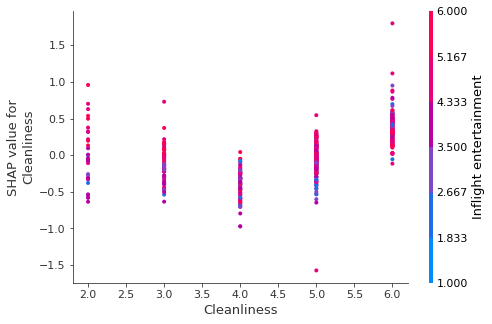

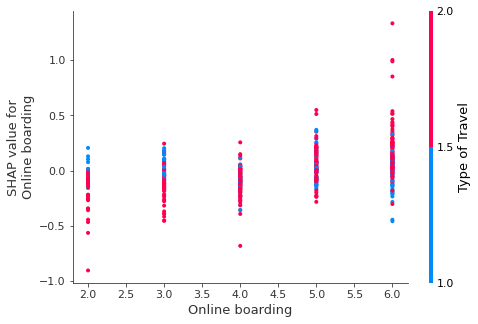

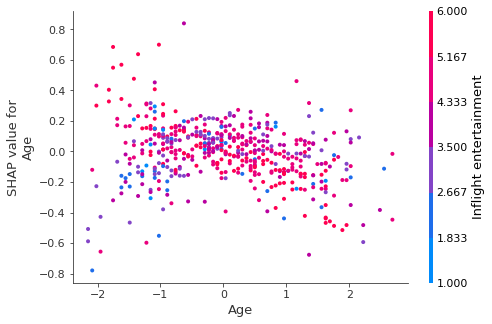

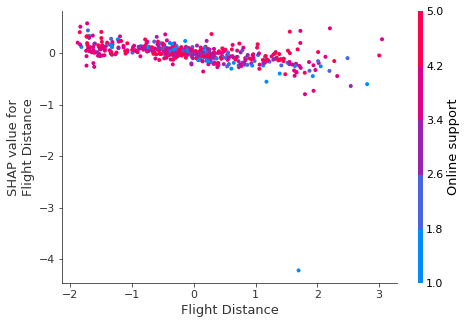

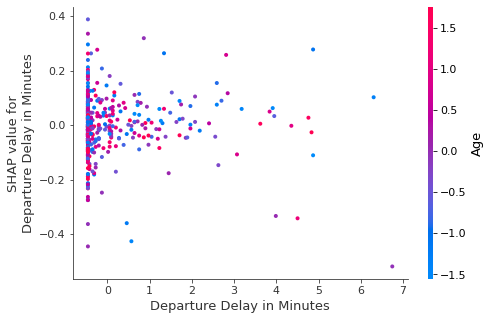

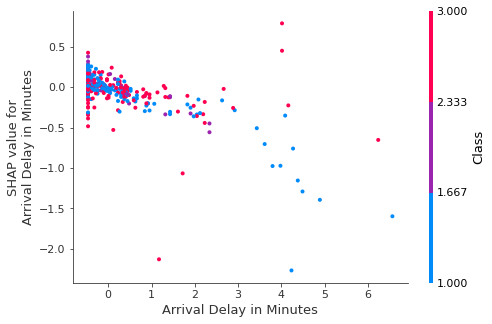

In [ ]:
for name in X_test.columns:
    shap.dependence_plot(name, shap_values[1], X_test)

in den beiden *Summary plots* sind die Variablen von oben nach unten absteigend nach ihrem durschnittlichen Einfluss auf die Vorhersage geordnet. Im ersten Schaubild ist zudem die Verteilung der SHAP-Werte pro Variable in Abhängigkeit von den Variablenwerten der Fluggäste ablesbar.

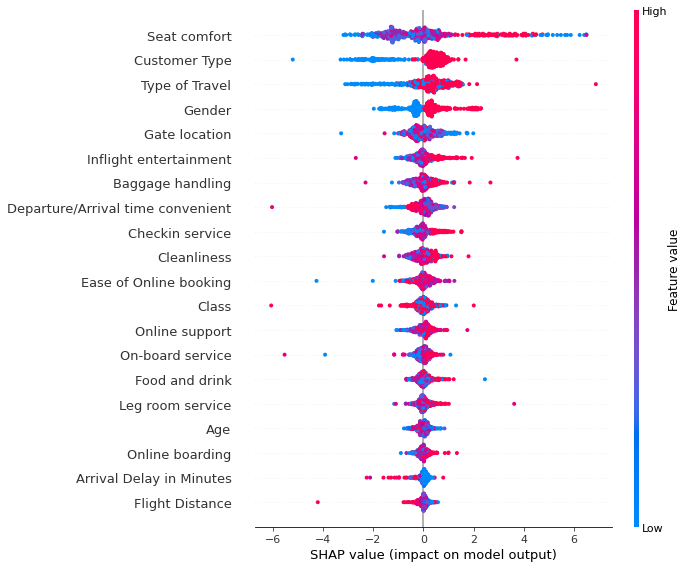

In [ ]:
shap.summary_plot(shap_values[1], X_test)

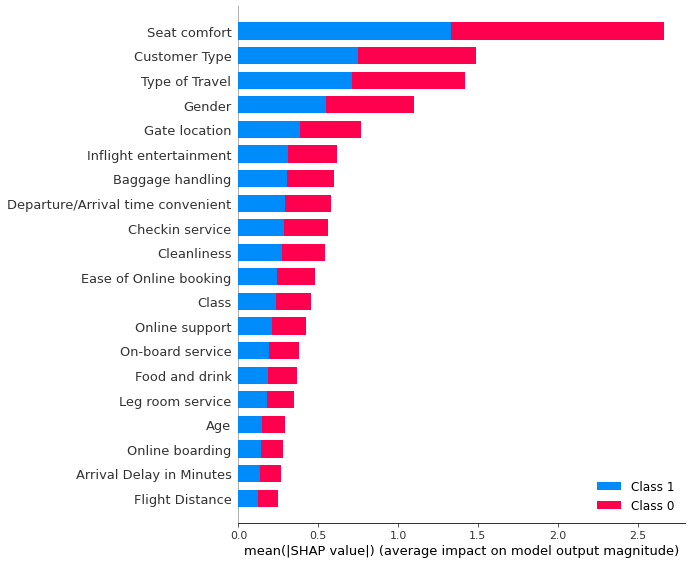

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Die letzte Grafik zeigt die Einflüsse der Variablen auf die Vorhersagen für alle 500 Einträge des Teildatensatzes. Dabei sind die Beobachtungen nach ihrer Ähnlichkeit geordnet.

In [ ]:
shap.initjs()
shap.force_plot(e.expected_value[1], shap_values[1], X_test, link='logit')